## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'efficientnet-exp001'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

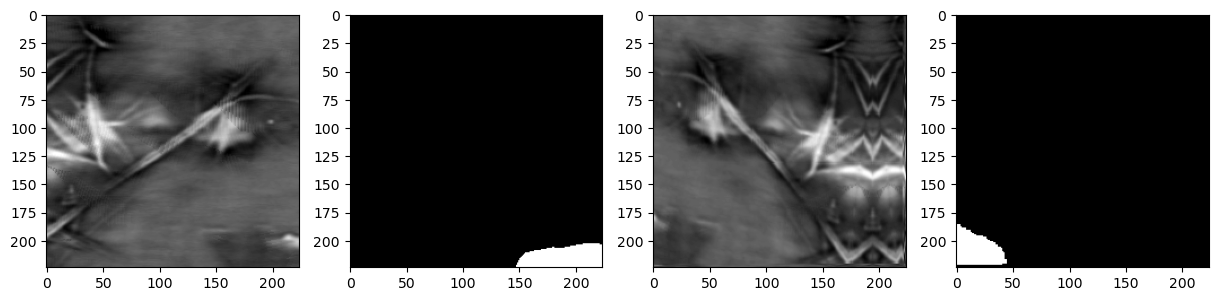

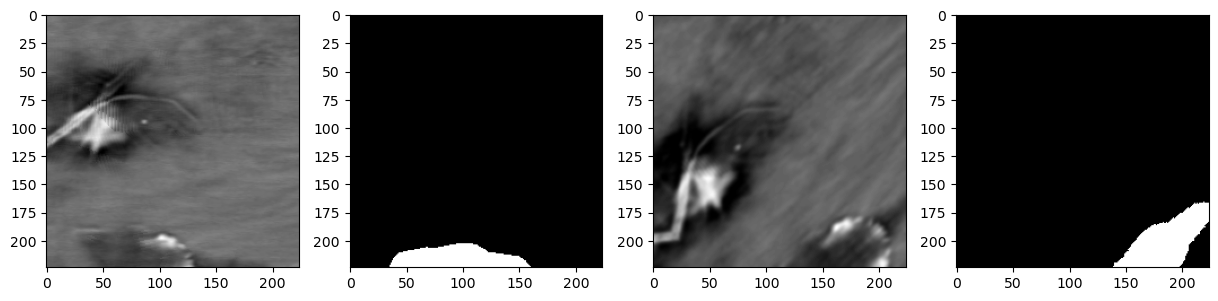

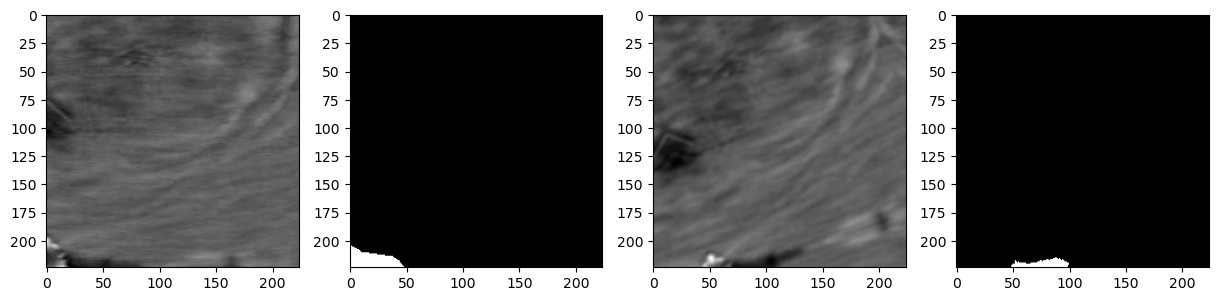

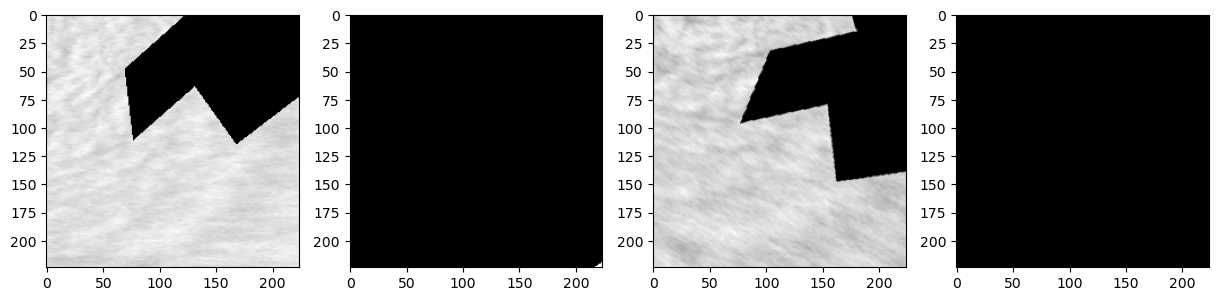

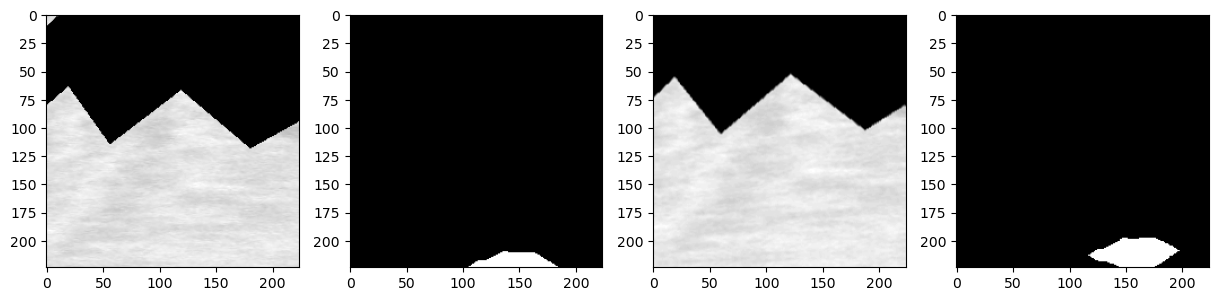

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1209679998211461
th: 0.15, fbeta: 0.12096933675118832
th: 0.2, fbeta: 0.12092480176779963
th: 0.25, fbeta: 0.12062183030165506
th: 0.3, fbeta: 0.1200705700562389
th: 0.35, fbeta: 0.12015533434753016
th: 0.4, fbeta: 0.20818034186526457
th: 0.45, fbeta: 0.21999856055925948


best_th: 0.45, fbeta: 0.21999856055925948
Epoch 1 - avg_train_loss: 0.7066  avg_val_loss: 0.5609  time: 175s
Epoch 1 - avgScore: 0.2200
Epoch 1 - Save Best Score: 0.2200 Model
Epoch 1 - Save Best Loss: 0.5609 Model


th: 0.5, fbeta: 0.21517133493415988


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1209648096611867
th: 0.15, fbeta: 0.12096908160152477
th: 0.2, fbeta: 0.12734681955187346
th: 0.25, fbeta: 0.2183886899053963
th: 0.3, fbeta: 0.23923519737609783
th: 0.35, fbeta: 0.25988790275691864
th: 0.4, fbeta: 0.27340416739259715
th: 0.45, fbeta: 0.26837795172927725


best_th: 0.4, fbeta: 0.27340416739259715
Epoch 2 - avg_train_loss: 0.5035  avg_val_loss: 0.4102  time: 178s
Epoch 2 - avgScore: 0.2734
Epoch 2 - Save Best Score: 0.2734 Model
Epoch 2 - Save Best Loss: 0.4102 Model


th: 0.5, fbeta: 0.21288381342790513


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2821542482115343
th: 0.15, fbeta: 0.3394735278091933
th: 0.2, fbeta: 0.37684278053268816
th: 0.25, fbeta: 0.4058956660033419
th: 0.3, fbeta: 0.4307182024837017
th: 0.35, fbeta: 0.4414620201103987
th: 0.4, fbeta: 0.42780753527248533
th: 0.45, fbeta: 0.38833975822352956


best_th: 0.35, fbeta: 0.4414620201103987
Epoch 3 - avg_train_loss: 0.3069  avg_val_loss: 0.2477  time: 180s
Epoch 3 - avgScore: 0.4415
Epoch 3 - Save Best Score: 0.4415 Model
Epoch 3 - Save Best Loss: 0.2477 Model


th: 0.5, fbeta: 0.3191280450367734


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35250320616134256
th: 0.15, fbeta: 0.405134685755048
th: 0.2, fbeta: 0.43470442551019794
th: 0.25, fbeta: 0.45006569811078984
th: 0.3, fbeta: 0.4536343439318038
th: 0.35, fbeta: 0.4469103470391098
th: 0.4, fbeta: 0.4282557089314072
th: 0.45, fbeta: 0.40460819435548384


best_th: 0.3, fbeta: 0.4536343439318038
Epoch 4 - avg_train_loss: 0.2496  avg_val_loss: 0.2457  time: 180s
Epoch 4 - avgScore: 0.4536
Epoch 4 - Save Best Score: 0.4536 Model
Epoch 4 - Save Best Loss: 0.2457 Model


th: 0.5, fbeta: 0.36954943696340337


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32863588876469857
th: 0.15, fbeta: 0.3766264461029054
th: 0.2, fbeta: 0.41582389233130046
th: 0.25, fbeta: 0.44868424257758965
th: 0.3, fbeta: 0.4720824293970212
th: 0.35, fbeta: 0.48389827917609934
th: 0.4, fbeta: 0.4851050807924044
th: 0.45, fbeta: 0.4797527430269181


best_th: 0.4, fbeta: 0.4851050807924044
Epoch 5 - avg_train_loss: 0.2377  avg_val_loss: 0.2334  time: 180s
Epoch 5 - avgScore: 0.4851
Epoch 5 - Save Best Score: 0.4851 Model
Epoch 5 - Save Best Loss: 0.2334 Model


th: 0.5, fbeta: 0.4664401350316347


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35308561439127023
th: 0.15, fbeta: 0.3859626962825265
th: 0.2, fbeta: 0.4097578895148323
th: 0.25, fbeta: 0.42845448711089207
th: 0.3, fbeta: 0.4426145218685177
th: 0.35, fbeta: 0.4529777972247814
th: 0.4, fbeta: 0.45842817883645487
th: 0.45, fbeta: 0.46176208643647937


best_th: 0.5, fbeta: 0.46197555328921847
Epoch 6 - avg_train_loss: 0.2294  avg_val_loss: 0.2450  time: 179s
Epoch 6 - avgScore: 0.4620


th: 0.5, fbeta: 0.46197555328921847


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3345105786004434
th: 0.15, fbeta: 0.3700018528656999
th: 0.2, fbeta: 0.40069659874739133
th: 0.25, fbeta: 0.4238006969890404
th: 0.3, fbeta: 0.4400243720211961
th: 0.35, fbeta: 0.45364243713449626
th: 0.4, fbeta: 0.46251171801216473
th: 0.45, fbeta: 0.4667103577321507


best_th: 0.45, fbeta: 0.4667103577321507
Epoch 7 - avg_train_loss: 0.2232  avg_val_loss: 0.2399  time: 180s
Epoch 7 - avgScore: 0.4667


th: 0.5, fbeta: 0.46520997934172964


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33471036220687006
th: 0.15, fbeta: 0.36509438303927577
th: 0.2, fbeta: 0.38333950997776334
th: 0.25, fbeta: 0.39606636819914237
th: 0.3, fbeta: 0.4064580328918262
th: 0.35, fbeta: 0.41487984559286484
th: 0.4, fbeta: 0.42100752982488004
th: 0.45, fbeta: 0.4280780287169005


best_th: 0.5, fbeta: 0.43401473442206817
Epoch 8 - avg_train_loss: 0.2168  avg_val_loss: 0.2523  time: 180s
Epoch 8 - avgScore: 0.4340


th: 0.5, fbeta: 0.43401473442206817


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37015033120897084
th: 0.15, fbeta: 0.39801888268848173
th: 0.2, fbeta: 0.4163222850980842
th: 0.25, fbeta: 0.42884245783520614
th: 0.3, fbeta: 0.43932349860401326
th: 0.35, fbeta: 0.4498470295177851
th: 0.4, fbeta: 0.4586392668815577
th: 0.45, fbeta: 0.46366550184874944


best_th: 0.5, fbeta: 0.46647760350651424
Epoch 9 - avg_train_loss: 0.2115  avg_val_loss: 0.2613  time: 180s
Epoch 9 - avgScore: 0.4665


th: 0.5, fbeta: 0.46647760350651424


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38030103505399515
th: 0.15, fbeta: 0.4106996839079355
th: 0.2, fbeta: 0.43023757101847
th: 0.25, fbeta: 0.44764760656971136
th: 0.3, fbeta: 0.46072343939110316
th: 0.35, fbeta: 0.46965208688515303
th: 0.4, fbeta: 0.47574469779470324
th: 0.45, fbeta: 0.47701024958007254


best_th: 0.45, fbeta: 0.47701024958007254
Epoch 10 - avg_train_loss: 0.2075  avg_val_loss: 0.2500  time: 181s
Epoch 10 - avgScore: 0.4770


th: 0.5, fbeta: 0.47196230247534016


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3928646195650238
th: 0.15, fbeta: 0.4146679921768726
th: 0.2, fbeta: 0.4278895786573313
th: 0.25, fbeta: 0.43562993504613506
th: 0.3, fbeta: 0.4385872497888538
th: 0.35, fbeta: 0.44073601723743505
th: 0.4, fbeta: 0.43775087307965815
th: 0.45, fbeta: 0.42937544964149693


best_th: 0.35, fbeta: 0.44073601723743505
Epoch 11 - avg_train_loss: 0.2019  avg_val_loss: 0.2814  time: 180s
Epoch 11 - avgScore: 0.4407


th: 0.5, fbeta: 0.4145868244386461


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3697248102606497
th: 0.15, fbeta: 0.39685944621039176
th: 0.2, fbeta: 0.41361433575455275
th: 0.25, fbeta: 0.4257168340398865
th: 0.3, fbeta: 0.43594676371458924
th: 0.35, fbeta: 0.44447251738064675
th: 0.4, fbeta: 0.45249721539099
th: 0.45, fbeta: 0.45448177607479934


best_th: 0.45, fbeta: 0.45448177607479934
Epoch 12 - avg_train_loss: 0.1961  avg_val_loss: 0.2579  time: 180s
Epoch 12 - avgScore: 0.4545


th: 0.5, fbeta: 0.45437917016680873


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41187406353274086
th: 0.15, fbeta: 0.444151192982994
th: 0.2, fbeta: 0.464012783213082
th: 0.25, fbeta: 0.4751446805383385
th: 0.3, fbeta: 0.48297648297234447
th: 0.35, fbeta: 0.48726771649119704
th: 0.4, fbeta: 0.48405369229626694
th: 0.45, fbeta: 0.47689116123786934


best_th: 0.35, fbeta: 0.48726771649119704
Epoch 13 - avg_train_loss: 0.1950  avg_val_loss: 0.2693  time: 180s
Epoch 13 - avgScore: 0.4873
Epoch 13 - Save Best Score: 0.4873 Model
Epoch 13 - Save Best Loss: 0.2693 Model


th: 0.5, fbeta: 0.4679435584853435


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3905026236749521
th: 0.15, fbeta: 0.4173609162216273
th: 0.2, fbeta: 0.43584320665565834
th: 0.25, fbeta: 0.44932792849811143
th: 0.3, fbeta: 0.46294167524385393
th: 0.35, fbeta: 0.47198840971443684
th: 0.4, fbeta: 0.4733070324562654
th: 0.45, fbeta: 0.46947999728004436


best_th: 0.4, fbeta: 0.4733070324562654
Epoch 14 - avg_train_loss: 0.1919  avg_val_loss: 0.2634  time: 180s
Epoch 14 - avgScore: 0.4733


th: 0.5, fbeta: 0.4614979309484092


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39615643925682326
th: 0.15, fbeta: 0.421811267388484
th: 0.2, fbeta: 0.4404322015812504
th: 0.25, fbeta: 0.4541532373298365
th: 0.3, fbeta: 0.46548309091908663
th: 0.35, fbeta: 0.47172706320408064
th: 0.4, fbeta: 0.47244223420124254
th: 0.45, fbeta: 0.4688165585267592


best_th: 0.4, fbeta: 0.47244223420124254
Epoch 15 - avg_train_loss: 0.1905  avg_val_loss: 0.2657  time: 180s
Epoch 15 - avgScore: 0.4724


th: 0.5, fbeta: 0.4592317291622665


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41187406353274086
th: 0.15, fbeta: 0.444151192982994
th: 0.2, fbeta: 0.464012783213082
th: 0.25, fbeta: 0.4751446805383385
th: 0.3, fbeta: 0.48297648297234447
th: 0.35, fbeta: 0.48726771649119704
th: 0.4, fbeta: 0.48405369229626694
th: 0.45, fbeta: 0.47689116123786934


best_th: 0.35, fbeta: 0.48726771649119704


th: 0.5, fbeta: 0.4679435584853435


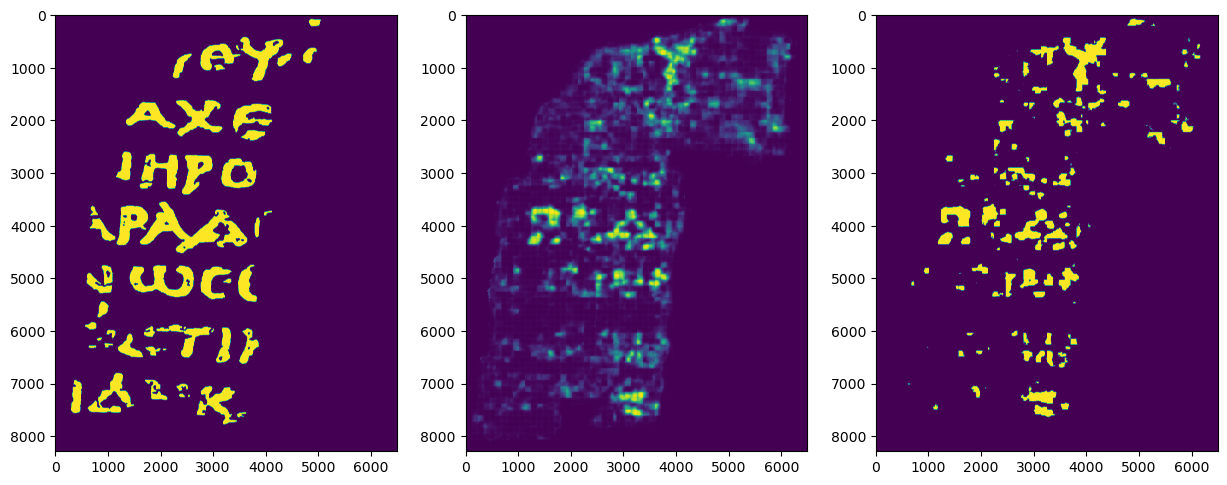

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([41167019.,  3995259.,  2227002.,  1451588.,  1030806.,   730321.,
          549602.,   430302.,   369820.,   293403.,   257148.,   224071.,
          186603.,   162982.,   157408.,   146462.,   146428.,   138417.,
          113664.,    60543.]),
 array([1.20440087e-04, 4.97199382e-02, 9.93194362e-02, 1.48918934e-01,
        1.98518432e-01, 2.48117930e-01, 2.97717428e-01, 3.47316927e-01,
        3.96916425e-01, 4.46515923e-01, 4.96115421e-01, 5.45714919e-01,
        5.95314417e-01, 6.44913915e-01, 6.94513413e-01, 7.44112911e-01,
        7.93712409e-01, 8.43311907e-01, 8.92911405e-01, 9.42510903e-01,
        9.92110401e-01]),
 <BarContainer object of 20 artists>)

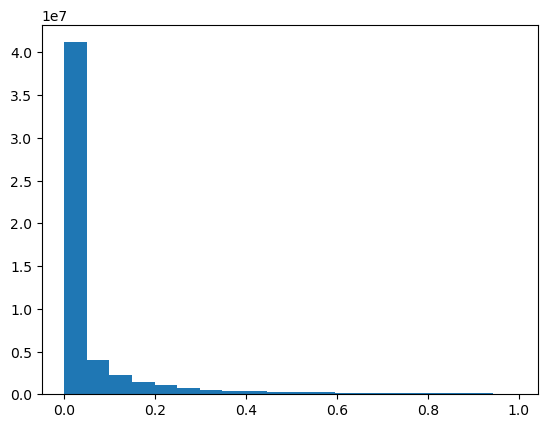

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000